Final

In [167]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.arima_model import ARIMA, ARMAResults 
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import os, gc, pickle, copy, datetime
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots


import seaborn as sns
import lightgbm as lgb
from sklearn import metrics
pd.set_option('display.max_columns', 100)
warnings.filterwarnings('ignore')

/kaggle/input/covid19-global-forecasting-week-1/submission.csv
/kaggle/input/covid19-global-forecasting-week-1/test.csv
/kaggle/input/covid19-global-forecasting-week-1/train.csv


In [168]:
datapath   = '../input/covid19-global-forecasting-week-1/'
train      = pd.read_csv(datapath+'train.csv')
test       = pd.read_csv(datapath+'test.csv')

def RMSLE(pred,actual):
    return np.sqrt(np.mean(np.power((np.log(pred+1)-np.log(actual+1)),2)))

def calc_score(y_true, y_pred):
    y_true[y_true<0] = 0
    score = metrics.mean_squared_error(np.log(y_true.clip(0, 1e10)+1), np.log(y_pred[:]+1))**0.5
    return score
pd.set_option('mode.chained_assignment', None)
df_traintest = pd.concat([train, test])

In [169]:
print("Train dataset: ", train.head())
print("Train period: ", train.Date.min(), train.Date.max())
print("Test dataset: ", test.head())
print("Test period: ", test.Date.min(), test.Date.max())

Train dataset:     Id Province/State Country/Region   Lat  Long        Date  ConfirmedCases  \
0   1            NaN    Afghanistan  33.0  65.0  2020-01-22             0.0   
1   2            NaN    Afghanistan  33.0  65.0  2020-01-23             0.0   
2   3            NaN    Afghanistan  33.0  65.0  2020-01-24             0.0   
3   4            NaN    Afghanistan  33.0  65.0  2020-01-25             0.0   
4   5            NaN    Afghanistan  33.0  65.0  2020-01-26             0.0   

   Fatalities  
0         0.0  
1         0.0  
2         0.0  
3         0.0  
4         0.0  
Train period:  2020-01-22 2020-03-24
Test dataset:     ForecastId Province/State Country/Region   Lat  Long        Date
0           1            NaN    Afghanistan  33.0  65.0  2020-03-12
1           2            NaN    Afghanistan  33.0  65.0  2020-03-13
2           3            NaN    Afghanistan  33.0  65.0  2020-03-14
3           4            NaN    Afghanistan  33.0  65.0  2020-03-15
4           5        

EDA

Train Date type:  datetime64[ns]
Test Date type:  datetime64[ns]


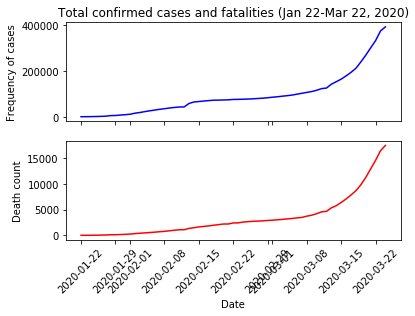

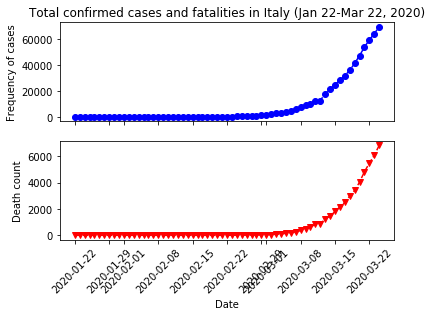

How many places?:  Train:  284 Test:  284
Unique place similar as test?:  284


In [181]:


train['Date'] = train['Date'].astype('datetime64[ns]')
test['Date'] = test['Date'].astype('datetime64[ns]')

print("Train Date type: ", train['Date'].dtype)
print("Test Date type: ",test['Date'].dtype)

train.columns = ['id','state','country','lat','lon','date','ConfirmedCases','Fatalities']
test.columns  = ['ForecastId', 'state','country','lat','lon','date']

train['place'] = train['state'].fillna('') + '_' + train['country']
test['place'] = test['state'].fillna('') + '_' + test['country']

fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(train.groupby('date')['ConfirmedCases'].sum(),color='blue')
ax[1].plot(train.groupby('date')['Fatalities'].agg(sum),color='red')

ax[0].set_ylabel('Frequency of cases')
ax[1].set_ylabel('Death count')
ax[1].set_xlabel('Date')
plt.xticks(rotation=45)

ax[0].set_title('Total confirmed cases and fatalities (Jan 22-Mar 22, 2020)')
plt.show()

china_cases     = train[train['place'].str.contains('Italy')][['date',
                                                               'ConfirmedCases',
                                                               'Fatalities']].reset_index(drop=True)
restworld_cases = train[-train['place'].str.contains('Italy')][['date',
                                                                'ConfirmedCases',
                                                                'Fatalities']].reset_index(drop=True)


#plot total confirmed cases and fatalities in Italy (Jan 22-Mar 22, 2020)

fig,ax = plt.subplots(2,1, sharex=True)
ax[0].plot(china_cases.groupby('date')['ConfirmedCases'].sum(), marker='o',color='b', 
            linestyle='--')
ax[1].plot(china_cases.groupby('date')['Fatalities'].sum(), marker='v',color='r',
            linestyle='--')
ax[0].set_ylabel('Frequency of cases')
ax[1].set_ylabel('Death count')
ax[1].set_xlabel('Date')
plt.xticks(rotation=45)

ax[0].set_title('Total confirmed cases and fatalities in Italy (Jan 22-Mar 22, 2020)')
plt.show()

print('How many places?: ', 'Train: ', len(train['place'].unique()), 
      'Test: ', len(test['place'].unique()))
print('Unique place similar as test?: ',(train['place'].unique() == test['place'].unique()).sum())


train_sub = train[['id','place','date','ConfirmedCases','Fatalities']] 
train_sub['logConfirmedCases'] = np.log(train_sub['ConfirmedCases'])
train_sub = train_sub.set_index('date')


list= []


TRY POLYNOMIAL REGRESSION

In [183]:
from numpy import inf
train_sub['logConfirmedCases']= train_sub['logConfirmedCases'].replace(to_replace=-inf,
                                                                      value=0)

poly_data = train[['date','place',
                  'ConfirmedCases','Fatalities']].merge(test[['date','place']], 
                                                      how='outer', 
                                                        on=['date','place']).sort_values(['place',
                                                                                          'date'])



# create label for each date by each place
label = []
for place in poly_data.place.unique():
    labelrange = range(1,len(poly_data[poly_data['place']==place])+1)
    label.append([i for i in labelrange])
lab = [item for lab in label for item in lab]
poly_data['label'] = lab
poly_data.head()

#Split train and test
XYtrain = poly_data[(poly_data['date']>'2020-01-21')&((poly_data['date']<'2020-03-25'))]


XYtest = poly_data[(poly_data['date']>'2020-03-11')&(poly_data['date']<'2020-04-24')]

#Confirmed Cases

XYtrain['intercept']= -1

result=pd.DataFrame()
for place in poly_data.place.unique():
    #Try degree with 2,3,4,5
    for degree in [2,3,4,5]:
        features  = XYtrain[XYtrain['place']==place][['label','intercept']]
        target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
        model  = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(np.array(features), target)
        y_pred = model.predict(np.array(features))
        rmsle  = RMSLE(y_pred, target)
        result = result.append(pd.DataFrame({'place':[place],
                                             'degree':[degree],'RMSLE': [rmsle]}))
        
best_degree = pd.DataFrame()
for place in result.place.unique():
    a = result[result['place']==place]
    best_degree = best_degree.append(a[a['RMSLE'] == a['RMSLE'].min()])


fit_best_degree = best_degree[best_degree['RMSLE']>0.00001]
twodeg_places   = fit_best_degree[fit_best_degree['degree']==2]['place'].unique()
threedeg_places = fit_best_degree[fit_best_degree['degree']==3]['place'].unique()
fourdeg_places  = fit_best_degree[fit_best_degree['degree']==4]['place'].unique()
fivedeg_places  = fit_best_degree[fit_best_degree['degree']==5]['place'].unique()
nofit_places1    = best_degree[best_degree['RMSLE']<0.00001]['place'].unique()
#Print the RMSLE
print('RMSLE:',fit_best_degree['RMSLE'].mean())


#Predict for Comfirmed Cases

XYtest = XYtest.reset_index(drop=True)
XYtest['intercept'] = -1

poly_predicted_confirmedcases = pd.DataFrame() 
#Predict with degree 2,3,4,5 and combine the result together.
for place in twodeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(2), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    a = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(a)
    
for place in threedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(3), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    b = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(b)
    
    
for place in fourdeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(4), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    c = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(c)
    
    
for place in fivedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['ConfirmedCases']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    d = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(d)

    
#Fatalities, which is similar to confirmed cases
fatalities_result=pd.DataFrame()
for place in poly_data.place.unique():
    for degree in [2,3,4,5]:
        features  = XYtrain[XYtrain['place']==place][['label','intercept']]
        target    = XYtrain[XYtrain['place']==place]['Fatalities']
        model  = make_pipeline(PolynomialFeatures(degree), Ridge())
        model.fit(np.array(features), target)
        y_pred = model.predict(np.array(features))
        rmsle  = RMSLE(y_pred, target)
        fatalities_result = fatalities_result.append(pd.DataFrame({'place':[place],
                                             'degree':[degree],'RMSLE': [rmsle]}))

fat_best_degree = pd.DataFrame()
for place in fatalities_result.place.unique():
    a = fatalities_result[fatalities_result['place']==place]
    fat_best_degree = fat_best_degree.append(a[a['RMSLE'] == a['RMSLE'].min()])
#print(fat_best_degree.groupby('degree')['place'].nunique())
#print('Zero polynomial (no fit): ',
      #fat_best_degree[fat_best_degree['RMSLE']<0.000001]['place'].unique())

fit_best_degree = fat_best_degree[fat_best_degree['RMSLE']>0.000001]
twodeg_places   = fit_best_degree[fit_best_degree['degree']==2]['place'].unique()
threedeg_places = fit_best_degree[fit_best_degree['degree']==3]['place'].unique()
fourdeg_places  = fit_best_degree[fit_best_degree['degree']==4]['place'].unique()
fivedeg_places  = fit_best_degree[fit_best_degree['degree']==5]['place'].unique()
nofit_places2    = fat_best_degree[fat_best_degree['RMSLE']<0.000001]['place'].unique()
#print(len(twodeg_places), len(threedeg_places), 
      #len(fourdeg_places), len(fivedeg_places), len(nofit_places2))

poly_predicted_fatalities = pd.DataFrame() 
for place in twodeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(2), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    a = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(a)
    
for place in threedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(3), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    b = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(b)
    
    
for place in fourdeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(4), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    c = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(c)
    
    
for place in fivedeg_places:
    features  = XYtrain[XYtrain['place']==place][['label','intercept']]
    target    = XYtrain[XYtrain['place']==place]['Fatalities']
    Xtest     = XYtest[XYtest['place']==place][['label','intercept']]
    model  = make_pipeline(PolynomialFeatures(5), Ridge())
    model.fit(np.array(features), target)
    y_pred = model.predict(np.array(Xtest))
    d = pd.DataFrame(zip(XYtrain[XYtrain['place']==place]['place'], 
                              y_pred.tolist()),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(d)

# forward fill no fit places for confirmed cases
for place in nofit_places1:
    e = poly_data[(poly_data['place']==place) & (poly_data['date']>'2020-03-11')]
    f = e['ConfirmedCases'].fillna(method = 'ffill')
    g = pd.DataFrame(zip(e['place'], f),columns=['place','ConfirmedCases'])
    poly_predicted_confirmedcases = poly_predicted_confirmedcases.append(g)

# forward fill no fit places for fatalities
for place in nofit_places2:
    h = poly_data[(poly_data['place']==place) & (poly_data['date']>'2020-03-11')]
    i = h['Fatalities'].fillna(method = 'ffill')
    j = pd.DataFrame(zip(h['place'], i),columns=['place','Fatalities'])
    poly_predicted_fatalities = poly_predicted_fatalities.append(j)
    
poly_predicted_confirmedcases2= pd.DataFrame({'date':XYtest.date,
                                              'place':poly_predicted_confirmedcases['place'].tolist(),
                                              'ConfirmedCases':poly_predicted_confirmedcases['ConfirmedCases'].tolist()})
poly_predicted_confirmedcases2.head()

poly_predicted_fatalities2= pd.DataFrame({'date':XYtest.date,
                                              'place':poly_predicted_fatalities['place'].tolist(),
                                              'Fatalities':poly_predicted_fatalities['Fatalities'].tolist()})
poly_predicted_fatalities2.head()

poly_compiled = poly_predicted_confirmedcases2.merge(poly_predicted_fatalities2, how='inner', on=['place','date'])

test_poly_compiled= test.merge(poly_compiled, how='inner', on=['place','date'])
test_poly_compiled



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [172]:
# get the graph of Italy
country = "Italy"
a = test_poly_compiled[test_poly_compiled['country'] == country].groupby(['date','country']).sum().reset_index()

a = a[a['country'] == country].groupby(['date','country']).sum().reset_index()
idx = a[((test_poly_compiled['ConfirmedCases'].isnull() == False) & (a['ConfirmedCases'] > 0))].shape[0]
fig = px.line(a, x="date", y="ConfirmedCases", title='Total Cases of ' + a['country'].values[0])
fig.add_scatter(x=a['date'][0:idx], y=a['ConfirmedCases'][0:idx], mode='lines', name="Actual", showlegend=False)
fig.show()


Sarima

In [173]:
train = pd.read_csv(datapath+'train.csv')
test = pd.read_csv(datapath+'test.csv')

# check metadata of train
train['Province/State'].fillna('', inplace=True)
test['Province/State'].fillna('', inplace=True)
train['Date'] =  pd.to_datetime(train['Date'])
test['Date'] =  pd.to_datetime(test['Date'])
train = train.sort_values(['Country/Region','Province/State','Date'])
test = test.sort_values(['Country/Region','Province/State','Date'])
feature_day = [1,20,50,100,200,500,1000]
def CreateInput(data):
    feature = []
    for day in feature_day:
        #Get information in train data and focus on number day from fix number of cases
        data.loc[:,'Number day from ' + str(day) + ' case'] = 0
        if (train[(train['Country/Region'] == country) & (train['Province/State'] == province) & (train['ConfirmedCases'] < day)]['Date'].count() > 0):
            fromday = train[(train['Country/Region'] == country) & (train['Province/State'] == province) & (train['ConfirmedCases'] < day)]['Date'].max()        
        else:
            fromday = train[(train['Country/Region'] == country) & (train['Province/State'] == province)]['Date'].min()       
        for i in range(0, len(data)):
            if (data['Date'].iloc[i] > fromday):
                day_denta = data['Date'].iloc[i] - fromday
                data['Number day from ' + str(day) + ' case'].iloc[i] = day_denta.days 
        feature = feature + ['Number day from ' + str(day) + ' case']
    
    return data[feature]

pred_data_all = pd.DataFrame()
for country in train['Country/Region'].unique():
    for province in train[(train['Country/Region'] == country)]['Province/State'].unique():
        #prepare train, test
        df_train = train[(train['Country/Region'] == country) & (train['Province/State'] == province)]
        df_test = test[(test['Country/Region'] == country) & (test['Province/State'] == province)]
        X_train = CreateInput(df_train)
        y_train_confirmed = df_train['ConfirmedCases'].ravel()
        y_train_fatalities = df_train['Fatalities'].ravel()
        X_pred = CreateInput(df_test)
        
        for day in sorted(feature_day,reverse = True):
            feature_use = 'Number day from ' + str(day) + ' case'
            idx = X_train[X_train[feature_use] == 0].shape[0]     
            if (X_train[X_train[feature_use] > 0].shape[0] >= 20):
                break
                                    
        adjusted_X_train = X_train[idx:][feature_use].values.reshape(-1, 1)
        adjusted_y_train_confirmed = y_train_confirmed[idx:]
        adjusted_y_train_fatalities = y_train_fatalities[idx:] #.values.reshape(-1, 1)
        idx = X_pred[X_pred[feature_use] == 0].shape[0]    
        adjusted_X_pred = X_pred[idx:][feature_use].values.reshape(-1, 1)
        
        pred_data = test[(test['Country/Region'] == country) & (test['Province/State'] == province)]
        max_train_date = train[(train['Country/Region'] == country) & (train['Province/State'] == province)]['Date'].max()
        min_test_date = pred_data['Date'].min()
        #Use SARIMAX to train the model for confirmed cases
        model = SARIMAX(adjusted_y_train_confirmed, order=(1,1,0), 
                        #seasonal_order=(1,1,0,12),
                        measurement_error=True).fit(disp=False)
        y_hat_confirmed = model.forecast(pred_data[pred_data['Date'] > max_train_date].shape[0])
        y_train_confirmed = train[(train['Country/Region'] == country) & (train['Province/State'] == province) & (train['Date'] >=  min_test_date)]['ConfirmedCases'].values
        y_hat_confirmed = np.concatenate((y_train_confirmed,y_hat_confirmed), axis = 0)
        #Use SARIMAX to train the model for fatalities       
        model = SARIMAX(adjusted_y_train_fatalities, order=(1,1,0), 
                        #seasonal_order=(1,1,0,12),
                        measurement_error=True).fit(disp=False)
        y_hat_fatalities = model.forecast(pred_data[pred_data['Date'] > max_train_date].shape[0])
        y_train_fatalities = train[(train['Country/Region'] == country) & (train['Province/State'] == province) & (train['Date'] >=  min_test_date)]['Fatalities'].values
        y_hat_fatalities = np.concatenate((y_train_fatalities,y_hat_fatalities), axis = 0)
        
        #aggregate the prediction results
        pred_data['ConfirmedCases_hat'] =  y_hat_confirmed
        pred_data['Fatalities_hat'] = y_hat_fatalities
        pred_data_all = pred_data_all.append(pred_data)

df_val = pd.merge(pred_data_all,train[['Date','Country/Region','Province/State','ConfirmedCases','Fatalities']],on=['Date','Country/Region','Province/State'], how='left')
df_val.loc[df_val['Fatalities_hat'] < 0,'Fatalities_hat'] = 0
df_val.loc[df_val['ConfirmedCases_hat'] < 0,'ConfirmedCases_hat'] = 0
df_val_3 = df_val.copy()


In [174]:

#print the RMSLE
method_list = ['SARIMA']

method_score = [method_list[0]] + [RMSLE(df_val_3[(df_val_3['ConfirmedCases'].isnull() == False)]['ConfirmedCases'].values,df_val_3[(df_val_3['ConfirmedCases'].isnull() == False)]['ConfirmedCases_hat'].values)] + [RMSLE(df_val_3[(df_val_3['Fatalities'].isnull() == False)]['Fatalities'].values,df_val_3[(df_val_3['Fatalities'].isnull() == False)]['Fatalities_hat'].values)]
score = RMSLE(df_val_3[(df_val_3['ConfirmedCases'].isnull() == False)]['ConfirmedCases'].values, df_val_3[(df_val_3['ConfirmedCases'].isnull() == False)]['Fatalities'].values)
print ('RMSLE:',score)


RMSLE: 3.2996957023798226


In [175]:

#plot the prediction of Italy
country = "Italy"
df_country = df_val[df_val['Country/Region'] == country].groupby(['Date','Country/Region']).sum().reset_index()
idx = df_country[((df_country['ConfirmedCases_hat'].isnull() == False) & (df_country['ConfirmedCases_hat'] > 0))].shape[0]
fig = px.line(df_country, x="Date", y="ConfirmedCases_hat", title='Total Cases of ' + df_country['Country/Region'].values[0])
fig.add_scatter(x=df_country['Date'][0:idx], y=df_country['ConfirmedCases_hat'][0:idx], mode='lines', name="Actual", showlegend=False)
fig.show()


LightGBM

In [184]:
train = pd.read_csv(datapath+'train.csv')
test = pd.read_csv(datapath+'test.csv')
# concat Country/Region and Province/State
def func(x):
    try:
        x_new = x['Country/Region'] + "/" + x['Province/State']
    except:
        x_new = x['Country/Region']
    return x_new
# get place list        
df_traintest['place_id'] = df_traintest.apply(lambda x: func(x), axis=1)
tmp = np.sort(df_traintest['place_id'].unique())
# process date
df_traintest['Date'] = pd.to_datetime(df_traintest['Date'])
df_traintest['day'] = df_traintest['Date'].apply(lambda x: x.dayofyear).astype(np.int16)
df_traintest.head()
# calc cases, fatalities, recover per day
df_traintest2 = copy.deepcopy(df_traintest)
df_traintest2['cases/day'] = 0
df_traintest2['fatal/day'] = 0
tmp_list = np.zeros(len(df_traintest2))
places = np.sort(df_traintest['place_id'].unique())
for place in places:
    tmp = df_traintest2['ConfirmedCases'][df_traintest2['place_id']==place].values
    tmp[1:] -= tmp[:-1]
    df_traintest2['cases/day'][df_traintest2['place_id']==place] = tmp
    tmp = df_traintest2['Fatalities'][df_traintest2['place_id']==place].values
    tmp[1:] -= tmp[:-1]
    df_traintest2['fatal/day'][df_traintest2['place_id']==place] = tmp
df_traintest2[df_traintest2['place_id']=='China/Hubei'].head()

# aggregate cases and fatalities
def do_aggregation(df, col, mean_range):
    df_new = copy.deepcopy(df)
    col_new = '{}_({}-{})'.format(col, mean_range[0], mean_range[1])
    df_new[col_new] = 0
    tmp = df_new[col].rolling(mean_range[1]-mean_range[0]+1).mean()
    df_new[col_new][mean_range[0]:] = tmp[:-(mean_range[0])]
    df_new[col_new][pd.isna(df_new[col_new])] = 0
    return df_new[[col_new]].reset_index(drop=True)

def do_aggregations(df):
    df = pd.concat([df, do_aggregation(df, 'cases/day', [1,1]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'cases/day', [1,7]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'cases/day', [8,14]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'cases/day', [15,21]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'fatal/day', [1,1]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'fatal/day', [1,7]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'fatal/day', [8,14]).reset_index(drop=True)], axis=1)
    df = pd.concat([df, do_aggregation(df, 'fatal/day', [15,21]).reset_index(drop=True)], axis=1)
    for threshold in [1, 10, 100]:
        days_under_threshold = (df['ConfirmedCases']<threshold).sum()
        tmp = df['day'].values - 22 - days_under_threshold
        tmp[tmp<=0] = 0
        df['days_since_{}cases'.format(threshold)] = tmp
            
    for threshold in [1, 10, 100]:
        days_under_threshold = (df['Fatalities']<threshold).sum()
        tmp = df['day'].values - 22 - days_under_threshold
        tmp[tmp<=0] = 0
        df['days_since_{}fatal'.format(threshold)] = tmp
    
    # process China/Hubei
    if df['place_id'][0]=='China/Hubei':
        df['days_since_1cases'] += 35 # 2019/12/8
        df['days_since_10cases'] += 35-13 # 2019/12/8-2020/1/2 assume 2019/12/8+13
        df['days_since_100cases'] += 4 # 2020/1/18
        df['days_since_1fatal'] += 13 # 2020/1/9
    return df
#aggregate cases and fatalities
df_traintest3 = []
for place in places[:]:
    df_tmp = df_traintest2[df_traintest2['place_id']==place].reset_index(drop=True)
    df_tmp = do_aggregations(df_tmp)
    df_traintest3.append(df_tmp)
df_traintest3 = pd.concat(df_traintest3).reset_index(drop=True)
df_traintest3[df_traintest3['place_id']=='China/Hubei'].head()


# train model to predict fatalities/day
# params
SEED = 42
params = {'num_leaves': 8,
          'min_data_in_leaf': 5,  # 42,
          'objective': 'regression',
          'max_depth': 8,
          'learning_rate': 0.02,
          'boosting': 'gbdt',
          'bagging_freq': 5,  # 5
          'bagging_fraction': 0.8,  # 0.5,
          'feature_fraction': 0.8201,
          'bagging_seed': SEED,
          'reg_alpha': 1,  # 1.728910519108444,
          'reg_lambda': 4.9847051755586085,
          'random_state': SEED,
          'metric': 'mse',
          'verbosity': 100,
          'min_gain_to_split': 0.02,  # 0.01077313523861969,
          'min_child_weight': 5,  # 19.428902804238373,
          'num_threads': 6,
          }


# train model to predict fatalities/day
col_target = 'fatal/day'
col_var = [
    'Lat', 'Long',
    'cases/day_(1-1)', 
    'cases/day_(1-7)', 
    'fatal/day_(1-7)', 
    'fatal/day_(8-14)', 
    'fatal/day_(15-21)', 
]

col_target2 = 'cases/day'
col_var2 = [
    'Lat', 'Long',
    'days_since_10cases', 
    'cases/day_(1-1)', 
    'cases/day_(1-7)', 
    'cases/day_(8-14)',  
    'cases/day_(15-21)', 
]
col_cat = []

df_train = df_traintest3[(pd.isna(df_traintest3['ForecastId'])) & (df_traintest3['day']<61)]
df_valid = df_traintest3[(pd.isna(df_traintest3['ForecastId'])) & (df_traintest3['day']>=61) & (df_traintest3['day']<72)]
df_test = df_traintest3[pd.isna(df_traintest3['ForecastId'])==False]
X_train = df_train[col_var]
X_valid = df_valid[col_var]
y_train = np.log(df_train[col_target].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
num_round = 15000
#use the params to train the model for confirmed cases.
model = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=1500,)

best_itr = model.best_iteration

y_true = df_valid['fatal/day'].values
y_pred = np.exp(model.predict(X_valid))-1
score = RMSLE(y_pred,y_true)
print("RMSLE:",score)

col_cat = []
df_train = df_traintest3[(pd.isna(df_traintest3['ForecastId'])) & (df_traintest3['day']<61)]
df_valid = df_traintest3[(pd.isna(df_traintest3['ForecastId'])) & (df_traintest3['day']>=61) & (df_traintest3['day']<72)]
df_test = df_traintest3[pd.isna(df_traintest3['ForecastId'])==False]
X_train = df_train[col_var2]
X_valid = df_valid[col_var2]
y_train = np.log(df_train[col_target2].values.clip(0, 1e10)+1)
y_valid = np.log(df_valid[col_target2].values.clip(0, 1e10)+1)
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=col_cat)
valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=col_cat)
#use the params to train the model for fatalities.
model2 = lgb.train(params, train_data, num_round, valid_sets=[train_data, valid_data],
                  verbose_eval=100,
                  early_stopping_rounds=1500,)
best_itr = model2.best_iteration

y_true = df_valid['cases/day'].values
y_pred = np.exp(model2.predict(X_valid))-1


Training until validation scores don't improve for 1500 rounds
[100]	training's l2: 0.0145248	valid_1's l2: 0.0391987
[200]	training's l2: 0.00981651	valid_1's l2: 0.0372954
[300]	training's l2: 0.00836132	valid_1's l2: 0.0401861
[400]	training's l2: 0.00751418	valid_1's l2: 0.0409198
[500]	training's l2: 0.00685248	valid_1's l2: 0.0417025
[600]	training's l2: 0.00644361	valid_1's l2: 0.0425312
[700]	training's l2: 0.00610752	valid_1's l2: 0.0432432
[800]	training's l2: 0.00587364	valid_1's l2: 0.042845
[900]	training's l2: 0.00574342	valid_1's l2: 0.0435178
[1000]	training's l2: 0.00574342	valid_1's l2: 0.0435178
[1100]	training's l2: 0.00574342	valid_1's l2: 0.0435178
[1200]	training's l2: 0.00574342	valid_1's l2: 0.0435178
[1300]	training's l2: 0.00574342	valid_1's l2: 0.0435178
[1400]	training's l2: 0.00574342	valid_1's l2: 0.0435178
[1500]	training's l2: 0.00574342	valid_1's l2: 0.0435178
[1600]	training's l2: 0.00574342	valid_1's l2: 0.0435178
Early stopping, best iteration is:
[

In [185]:
place = 'Italy'
#Use the model to predict Italy's confirmed cases
df_interest_base = df_traintest3[df_traintest3['place_id']==place].reset_index(drop=True)
df_interest = copy.deepcopy(df_interest_base)
df_interest['ConfirmedCases'] = df_interest['ConfirmedCases'].astype(np.float)
df_interest['cases/day'] = df_interest['cases/day'].astype(np.float)
df_interest['fatal/day'] = df_interest['fatal/day'].astype(np.float)
df_interest['Fatalities'] = df_interest['Fatalities'].astype(np.float)
df_interest['cases/day'][df_interest['day']>=72] = -1
df_interest['fatal/day'][df_interest['day']>=72] = -1
len_known = (df_interest['cases/day']!=-1).sum()
len_unknown = (df_interest['cases/day']==-1).sum()
X_valid = df_interest[col_var][df_interest['day']>=72]
X_valid2 = df_interest[col_var2][df_interest['day']>=72]
pred_f =  np.exp(model.predict(X_valid))-1
pred_c = np.exp(model2.predict(X_valid2))-1
df_interest['fatal/day'][df_interest['day']>=72] = pred_f.clip(0, 1e10)
df_interest['cases/day'][df_interest['day']>=72] = pred_c.clip(0, 1e10)
df_interest['Fatalities'] = np.cumsum(df_interest['fatal/day'].values)
df_interest['ConfirmedCases'] = np.cumsum(df_interest['cases/day'].values)
for j in range(len_unknown): 
    # use predicted cases and fatal for next days' prediction
    X_valid = df_interest[col_var].iloc[j+len_known]
    X_valid2 = df_interest[col_var2].iloc[j+len_known]
    pred_f = model.predict(X_valid)
    pred_c = model2.predict(X_valid2)
    pred_c = (np.exp(pred_c)-1).clip(0, 1e10)
    pred_f = (np.exp(pred_f)-1).clip(0, 1e10)
    df_interest['fatal/day'][j+len_known] = pred_f
    df_interest['cases/day'][j+len_known] = pred_c
    df_interest['Fatalities'][j+len_known] = df_interest['Fatalities'][j+len_known-1] + pred_f
    df_interest['ConfirmedCases'][j+len_known] = df_interest['ConfirmedCases'][j+len_known-1] + pred_c
    df_interest = df_interest.drop([
        'cases/day_(1-1)', 'cases/day_(1-7)', 'cases/day_(8-14)', 'cases/day_(15-21)', 
        'fatal/day_(1-1)', 'fatal/day_(1-7)', 'fatal/day_(8-14)', 'fatal/day_(15-21)', 
        'days_since_1cases', 'days_since_10cases', 'days_since_100cases',
        'days_since_1fatal', 'days_since_10fatal', 'days_since_100fatal',
                                   
                                   ],  axis=1)
    df_interest = do_aggregations(df_interest.reset_index(drop=True))

# visualize

df_country = df_interest[df_interest['Country/Region'] == place].groupby(['Date','Country/Region']).sum().reset_index()
idx = df_country[((df_country['ConfirmedCases'].isnull() == False) & (df_country['ConfirmedCases'] > 0))].shape[0]
fig = px.line(df_country, x="Date", y="ConfirmedCases", title='Total Cases of ' + df_country['Country/Region'].values[0])
fig.show()


